# Übung Einstieg Deep Reinforcemente Learning (Hausaufgabe #11)

Nehmt die [Aufgabe 10](https://colab.research.google.com/drive/1q5jG4cyuuX3mPgQDdkKz5rYch8hxo8Lz) als Basis und implementiert Q-Learning mit Replay Memory


## Übungssetup

### Teammitglieder Gruppe 3

- Hans Wermelinger
- Helmut Gehrer
- Markus Näpflin
- Nils Hryciuk
- Stefano Mavilio

### Laufzeitumgebung

Damit dieses Jupyter-Notebook ausgeführt werden kann, müssen folgende Module im aktuellen Python-Environment verfügbar sein:

- numpy
- math
- torch
- matplotlib
- pandas
- ucimlrepo
- torchviz

Alternativ kann es auch auf [Google Collab](https://colab.research.google.com/drive/1tohtPXhmdNVGt63S1VPErbeQK1YJNoMr?usp=sharing#scrollTo=78b7wKOj-hwB) ausgeführt werden.

<a href="https://colab.research.google.com/github/namarkus/BFH_CAS_AI_2024/blob/main/Day10/Workshop_Q_Learning_Dummy_Trader_mna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Daten

Wir verwenden für unser Beispiel Timeseries von schweizer Messstationen an mehreren Flüssen der Schweiz

- [Aare in Bern](https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2135)
- [Birs in Münchenstein](https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2106)
- [Sihl in Zürich](https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2176)

Die Serien enthalten pro Messpunkt

- Abflussmenge
- Wasserstand
- Wassertemperatur

### Ziel

Unser Agent (RiverSwimmer) soll sich möglichst weit fortbewegen und dabei nicht unterkühlen. Für die Fortbewegung hat er die folgenden drei Möglichkeiten:

- Laufen an Land (fixe Geschwindigkeit)
- Schwimmen in Ufernähe (Geschwindigkeit abhändig von Abflussmenge, aber gedrosselt duch Ufernähe)
- Schwimmen in der Flussmitte (Geschwindigkeit abhängig von Abflussmenge)

Aktion kann jeweils ein Übergang nach links oder rechts sein.

Sowohl Abflussmenge wie die Wassertemperatur können sich negativ oder positiv auf den Reward auswirken.

## Lösungsweg

### Vorberereitung Notebook

#### Generelle Konfigurationen

Generelle Importe

In [ ]:
from enum import Enum
import math
import itertools
import random
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

#### Setzen diverser Konstanten

In [ ]:
# --- Diverse Konstanten vordefinieren ---
TOTAL_EPISODES = 150 # Anzahl Iterationen
LOG_ONLY_LOCOMOTION_CHANGES = True #True: nur bei Zustandswechsel loggen; False alle Iterationen
DIE_ON_UNDERCOOLING = True # Abbruch bei Unterkühlung aktivieren?
INPUT_FEATURES = ['Abflussmenge', 'Wasserstand', 'Temperatur']
ADAPTED_FEATURES = ['Fliessgeschwindigkeit', 'Temperatur']
# Körpertemperaturen
DEFAULT_BODY_TEMPERATURE = 36.7
BODY_TEMPERATURE_UNDERCOOLING_FLIP = 33.5
UNDERCOOLING_THRESHOLD = 30.0
LOW_TEMPERATURE_CHANGE = 0.1
MEDIUM_TEMPERATURE_CHANGE = 0.2
HIGH_TEMPERATURE_CHANGE = 0.3

# Wassertemperaturen
LOW_TEMPERATURE_LOSS_IN_WATER_THRESHOLD = 18.0
MEDIUM_TEMPERATURE_LOSS_IN_WATER_THRESHOLD = 15.0
HIGH_TEMPERATURE_LOSS_IN_WATER_THRESHOLD = 12.0

# Wassergeschwindigkeit
WATER_SPEED_SWIM_RISK_THRESHOLD = 9.0

DEATH_PENALTY = -500.0

# Diverse Konstanten für Mechanismus
BATCH_SIZE = 91
GAMMA = 0.99
EPSILON_START = 0.9
EPSILON_END = 0.05
EPSILON_DECAY = 1000
TAU = 0.005
LR = 1e-4 # Lernrate

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)



### Daten importieren

Die Originaldaten haben wir in unserem Github-Repo abgelegt und holen sie hier von dort.

Dazu wird das npm Modul degit verwendet.

In [ ]:
!npm install degit

⠙⠹⠸⠼⠴
up to date, audited 2 packages in 835ms
⠴
found 0 vulnerabilities
⠴

#### Import der Files von GitHub

In [ ]:
!npx degit github:namarkus/BFH_CAS_AI_2024/Day10/Grp3/data#main data
! ls -al ./data

⠙! destination directory is not empty, aborting. Use --force to override
⠙total 40872
drwxrwxr-x 2 root root     4096 Jan 21 06:59  .
drwxr-xr-x 1 root root     4096 Jan 21 06:59  ..
-rw-r--r-- 1 root root    11742 Jan 15 15:55  aare_2024.csv
-rw-r--r-- 1 root root    39386 Jan 15 15:55  Aare_Bern_2135_Abfluss_Tagesmittel_2024-01-01_2024-12-31.csv
-rw-r--r-- 1 root root    39485 Jan 15 15:55  Aare_Bern_2135_Pegel_Tagesmittel_2024-01-01_2024-12-31.csv
-rw-r--r-- 1 root root    41155 Jan 15 15:55  Aare_Bern_2135_Wassertemperatur_Tagesmittel_2024-01-01_2024-12-31.csv
-rw-r--r-- 1 root root  4596414 Jan 15 15:55  birs_2024.csv
-rw-r--r-- 1 root root    23617 Jan 15 15:55  birs_2024_daily.csv
-rw-r--r-- 1 root root 15292170 Jan 15 15:55 'HBZHa547_Sihl-Blattwag_Abfluss m3_s Radar_11_ASCII-Tabelle.txt'
-rw-r--r-- 1 root root 16315565 Jan 15 15:55 'HBZHa547_Sihl-Blattwag_Pegel m ü.M., Radar_01_ASCII-Tabelle.txt'
-rw-r--r-- 1 root root  5348049 Jan 15 15:55  HBZHa547_Sihl-Blattwag_Wassertempera

#### Hilfsklasse River

Als Container für die Daten und mit Zusatzinformationen, welche in den Daten nicht vorkommen.

In [ ]:
class River:
  def __init__(self, input_file, width_at_monitor_station, danger_level = 10):
    self.width = width_at_monitor_station
    self.danger_level = danger_level
    self.input_data = pd.read_csv(input_file, index_col=0, parse_dates=True, delimiter=';')
    self.input_data.dropna(axis=0, how='all', inplace=True)
    print(f'Datei: {input_file}')
    print(self.input_data.head())
    self.input_data.sort_index(inplace=True)
    self.input_data['Fliessgeschwindigkeit'] = self.input_data.apply(lambda row: self.calculate_flow_speed(row['Abflussmenge'], row['Wasserstand']), axis=1)
    states = self.input_data[ADAPTED_FEATURES]
    print(states.head())
    self.states = states.to_numpy()

  def head(self, n=5):
    return self.input_data.head(n)

  def describe(self):
    return self.input_data.describe()

  def shape(self):
    return self.input_data.shape

  def calculate_flow_speed(self, total_flow: float, water_level: float) -> int:
    meters_per_second = total_flow / (self.width * water_level / 2) # m/s (Geschwindigkeit leicht getuned ;-)
    return meters_per_second * 360 # Turbo Rundung ;-)


#### River und unterschiedliche Datasets

In [ ]:
# Birs bei Münchenstein (Hofmatt) --> https://www.hydrodaten.admin.ch/de/seen-und-fluesse/stationen-und-daten/2106
birs = River('data/birs_2024_daily.csv', 20.0, 140.0)
aare = River('data/aare_2024.csv', 42, 360.0)
sihl = River('data/sihl_2020_2024_daily.csv', 8.0, 100.0)

Datei: data/birs_2024_daily.csv
            Abflussmenge  Wasserstand  Temperatur
Datum                                            
2024-01-01     14.739656   267.517247    7.241667
2024-01-02     15.009656   267.521549    7.337292
2024-01-03     34.878361   267.836726    8.381458
2024-01-04     29.465410   267.761670    8.398542
2024-01-05     24.217167   267.682122    7.715625
            Fliessgeschwindigkeit  Temperatur
Datum                                        
2024-01-01               1.983527    7.241667
2024-01-02               2.019828    7.337292
2024-01-03               4.688009    8.381458
2024-01-04               3.961563    8.398542
2024-01-05               3.256915    7.715625
Datei: data/aare_2024.csv
            Abflussmenge  Wasserstand  Temperatur
Datum                                            
2024-01-01       109.253      502.016        6.84
2024-01-02       109.371      502.017        6.88
2024-01-03       114.674      502.059        7.23
2024-01-04       126

Wir arbeiten nur mit einem Fluss weiter, können hier aber umschalten 😀

In [ ]:
#river = sihl
#river = birs
river = aare

In [ ]:
river.head()
# Wir benutzen nur Abf und Temp (Wassrestand vorläufig raus)
# Wir fassen drei Jahre  aus einzelne Tagesdruschschnitte zu 3*365 Scriit =1000Schriite
# wir entscheiden random, wenn er ins Wasser fäööt und beginnt (Zeitfernst ist zirkulär ) nice to have >>> am anfang immer in Tag 0 start

,Abflussmenge,Wasserstand,Temperatur,Fliessgeschwindigkeit
Datum,,,,
2024-01-01,109.253,502.016,6.84,3.730775
2024-01-02,109.371,502.017,6.88,3.734797
2024-01-03,114.674,502.059,7.23,3.915556
2024-01-04,126.812,502.152,7.07,4.329207
2024-01-05,136.545,502.224,6.84,4.660812


In [ ]:
river.shape()

(366, 4)

In [ ]:
river.describe()

,Abflussmenge,Wasserstand,Temperatur,Fliessgeschwindigkeit
count,366.000000,366.000000,366.000000,366.000000
mean,159.784115,502.346249,11.686448,5.450365
std,72.243755,0.485207,4.402855,2.458858
min,60.157000,501.596000,5.250000,2.055963
25%,96.804750,501.915750,7.545000,3.306352
50%,142.442500,502.266500,11.195000,4.861705
75%,209.563500,502.712250,15.080000,7.146276
max,326.184000,503.360000,21.580000,11.108800


In [ ]:
# df_returns = df0
# df_returns = pd.DataFrame()
# for name in df0.columns:
  # df_returns[name] = np.log(df0[name]).diff()

In [ ]:
 #df_returns.head()

In [ ]:
# split into train and test >>> vergessen; wir verwenden testeshalber zwei unterschiedliche Flüsse ;-)
#Ntest = df0.shape[0]//5
#train_data = df_returns.iloc[:-Ntest]
#test_data = df_returns.iloc[-Ntest:]


### Klassen unseres Modells

#### Replay Memory

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        transition = Transition(*args)
        #print(f'transition: {transition}')
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#### Q-Network

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#### Enum Action

Definiert die Aktionen, die der Agent ausführen kann

In [ ]:
class Action (Enum):
  MOVE_TOWARDS_LAND = -1
  STAY = 0
  MOVE_TOWARDS_DEEPER_WATER = 1

  def __init__(self, idx:int):
    self.idx = idx

  @property
  def direction (self) -> int:
    return self.idx


#### Enum CurrentLocomotion

Definiert die Fortbewegungsart unseres Agents im Environment

In [ ]:
class CurrentLocomotion (Enum):
  WALKING = (0, 1.0)
  SWIMMING_AT_THE_BORDER = (1, 0.75)
  SWIMMING_AT_SHORE = (2, 0.8)
  SWIMMING_NEAR_STREAM = (3, 0.9)
  SWIMMING_IN_STREAM = (4, 1.0)
  SWIMMING_IN_MIDDLE = (5, 1.5)

  def __init__(self, idx:int, speed_modifier:float):
    self.idx = idx
    self.speed_modifier = speed_modifier

  @property
  def speed_multiplier(self) -> float:
    return self.speed_modifier

  @property
  def position (self) -> int:
    return self.idx

  def successor(self, action:Action):
    if isinstance(action, torch.Tensor):
      action = action.item()
      new_index = self.idx + action
    else:
      new_index = self.idx + action.value
    if new_index < 0:
      return CurrentLocomotion.WALKING
    elif new_index >= len(CurrentLocomotion):
      return CurrentLocomotion.SWIMMING_IN_MIDDLE
    else:
      return next((loc for loc in CurrentLocomotion if loc.idx == new_index), None)


#### Klasse RiverSwimAgent

Der Agent, der aufgrund des erhaltenen States Entscheidungen trifft. Vorerst recht dumm, da er noch kein Feedback über die Auswirkungen seines Handelns erhält.

In [ ]:
class RiverSwimAgent:
  def __init__(self, walking_speed = 5.0, swimming_speed = 3.5):
    self.walking_speed = walking_speed
    self.swimming_speed = swimming_speed
    self.steps_done = 0
    self.possible_actions = list(Action)
    observation_count = len(ADAPTED_FEATURES) + 2 # Fluss-Features + Position + Körper-Temp
    action_count = len(Action)
    self.policy_net = DQN(observation_count, action_count).to(device)
    self.target_net = DQN(observation_count, action_count).to(device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
    self.replay_memory = ReplayMemory(10000)

  def act(self, state):
    sample = random.random()
    eps_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) *  math.exp(-1. * self.steps_done / EPSILON_DECAY)
    self.steps_done += 1
    if sample > eps_threshold:
      with torch.no_grad():
        net_result = self.policy_net(state)
        #print(f'net_result: {net_result}')
        max_index = torch.argmax(net_result)
        selected_action = self.possible_actions[max_index]
    else:
      selected_action = random.choice(self.possible_actions)
    return torch.tensor([selected_action.direction], device=device, dtype=torch.long)

  def remember(self, state, action, next_state, reward):
    self.replay_memory.push(state, action, next_state, reward)

  def replay(self, batch_size):
    if len(self.replay_memory) < batch_size:
        return
    transitions = self.replay_memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    action_batch = action_batch + 1 # unsere Actions sind sprechend, daher Wert um 1 shiften!
    reward_batch = torch.cat(batch.reward)
    replayed = self.policy_net(state_batch)
    state_action_values = torch.gather(replayed, 1, action_batch.unsqueeze(1))
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
      next_state_values[non_final_mask] = torch.argmax(self.target_net(non_final_next_states))
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    self.optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
    self.optimizer.step()


#### Klasse RiverSwimEnvironment

Die Umgebung, in welche sich unser Schimmer zurechtfinden muss.

In [ ]:
class RiverSwimEnvironment:
  def __init__(self, river:River, swimmer: RiverSwimAgent):
    self.river = river
    self.swimmer = swimmer
    self.current_idx = 0
    self._reset_values()

  def _build_state(self, index) -> torch.tensor:
    """ Baut den State, bestehend aus den beiden Attributen des Flusses und der aktuellen Körpertemperatur """
    return torch.tensor([self.river.states[index][0], self.river.states[index][1], self.current_locomotion.position, self.body_temperature], dtype=torch.float32).to(device)

  def reset(self):
    self.current_idx = 0
    self._reset_values()
    first_state = self._build_state(self.current_idx)
    self._log_after_step(None, 0.0, first_state, False)
    return first_state

  def _reset_values(self):
    self.covered_distance =  0.0 # zurückgelegte Strecke
    self.flow_distance_credit  = 0.0 # zurückgelegte "gratis" Strecke durch Wasserfluss
    self.body_temperature = DEFAULT_BODY_TEMPERATURE
    self.current_locomotion = CurrentLocomotion.WALKING
    # für Statistiken
    self.last_logged_locomotion_change = None
    self.steps_in_locomotion = [0] * len(CurrentLocomotion)
    self.steps_in_locomotion[self.current_locomotion.position] = 1

  # def get_possible_actions(self)  -> list[Action]:
  #   possible_actions = list(Action)
  #   if self.current_locomotion == CurrentLocomotion.WALKING:
  #     possible_actions = [action for action in possible_actions if action.name != "MOVE_TOWARDS_LAND"]
  #   if self.current_locomotion == CurrentLocomotion.SWIMMING_IN_MIDDLE:
  #     possible_actions = [action for action in possible_actions if action.name != "MOVE_TOWARDS_DEEPER_WATER"]
  #   return possible_actions

  def _reward(self, distance):
    risk_award = (WATER_SPEED_SWIM_RISK_THRESHOLD - self.river.states[self.current_idx][0]) / WATER_SPEED_SWIM_RISK_THRESHOLD
    if self.current_locomotion == CurrentLocomotion.WALKING:
      risk_award = risk_award * -1
    body_temperature_award = (self.body_temperature - BODY_TEMPERATURE_UNDERCOOLING_FLIP) * 5
    #print(f'Reward: {risk_award} + {body_temperature_award}' )
    return distance - self.swimmer.walking_speed + risk_award + body_temperature_award

  # def _rewards(self, distance):
  #   for action in Action:
  #     risk_award = (WATER_SPEED_SWIM_RISK_THRESHOLD - self.river.states[self.current_idx][0]) / WATER_SPEED_SWIM_RISK_THRESHOLD
  #     if self.current_locomotion == CurrentLocomotion.WALKING:
  #       risk_award = risk_award * -1
  #     body_temperature_award = (self.body_temperature - BODY_TEMPERATURE_UNDERCOOLING_FLIP) * 5
  #     #print(f'Reward: {risk_award} + {body_temperature_award}' )
  #     return distance - self.swimmer.walking_speed + risk_award + body_temperature_award

  def step(self, action:Action):
    """ Reagiert auf die Aktion des Agenten.
    - Aktualisiert das Environment aufgrund der Aktion
    - Berechnet den Reward für den Schritt
    - Reagiert auf Abbruchbedingungen (Ende Dataset, Unterkühlung)

    Gibt zurück:  (next_state, reward, done)
    """
    self.current_idx += 1  # move forward
    #if self.current_idx >= self.n:
    #  raise Exception("Episode already done")
    distance = self._update_environment(action)
    reward = self._reward(distance)
    next_state = self._build_state(self.current_idx)
    if DIE_ON_UNDERCOOLING and self.body_temperature < UNDERCOOLING_THRESHOLD:
      print('☠️ Schwimmer stirbt an Unterkühlung')
      done = True
      reward = DEATH_PENALTY
    else:
      done = (self.current_idx == len(self.river.states) - 1)
    self._log_after_step(action, reward, next_state, done)
    return next_state, torch.tensor([reward], dtype=torch.float32, device=device), done

  def _update_environment(self, action:Action):
    """
    Aktualisiert das Environment aufgrund der Aktion
    - Setzt die neue Fortbewegungsart.
    - Aktualisiert zurückgelegte Strecke und Körpertemperatur
    """
    self.current_locomotion = self.current_locomotion.successor(action)
    self.steps_in_locomotion[self.current_locomotion.position] += 1
    if self.current_locomotion == CurrentLocomotion.WALKING:
      distance = self.swimmer.walking_speed
      if self.body_temperature < DEFAULT_BODY_TEMPERATURE:
        self.body_temperature += MEDIUM_TEMPERATURE_CHANGE
    else:
      flow_distance = self.river.states[self.current_idx][0]  * self.current_locomotion.speed_multiplier
      distance = flow_distance + self.swimmer.swimming_speed
      self.flow_distance_credit += flow_distance
      water_temperature = self.river.states[self.current_idx][1]
      if water_temperature < HIGH_TEMPERATURE_LOSS_IN_WATER_THRESHOLD:
        self.body_temperature -= HIGH_TEMPERATURE_CHANGE
      elif water_temperature < MEDIUM_TEMPERATURE_LOSS_IN_WATER_THRESHOLD:
        self.body_temperature -= MEDIUM_TEMPERATURE_CHANGE
      elif water_temperature < LOW_TEMPERATURE_LOSS_IN_WATER_THRESHOLD:
        self.body_temperature -= LOW_TEMPERATURE_CHANGE
    self.covered_distance += distance
    return distance

  def _log_after_step(self, action, reward, next_state, done):
    if LOG_ONLY_LOCOMOTION_CHANGES:
      if self.current_locomotion == self.last_logged_locomotion_change:
        return
      self.last_logged_locomotion_change = self.current_locomotion

    match self.current_locomotion:
      case CurrentLocomotion.WALKING:
        locomotion_emoji = '🚶∽∽∽∽≈'
      case CurrentLocomotion.SWIMMING_AT_THE_BORDER:
        locomotion_emoji = '_🏊🏻‍♂️∽∽∽≈'
      case CurrentLocomotion.SWIMMING_AT_SHORE:
        locomotion_emoji = '_∽🏊🏻‍♂️∽∽≈'
      case CurrentLocomotion.SWIMMING_NEAR_STREAM:
        locomotion_emoji = '_∽∽🏊🏻‍♂️∽≈'
      case CurrentLocomotion.SWIMMING_IN_STREAM:
        locomotion_emoji = '_∽∽∽🏊🏻‍♂️≈'
      case CurrentLocomotion.SWIMMING_IN_MIDDLE:
        locomotion_emoji = '_∽∽∽∽🏊🏻‍♂️'
    action_visual = '?'
    match action:
      case Action.MOVE_TOWARDS_LAND:
        action_visual = '⬋'
      case Action.STAY:
        action_visual = '↓'
      case Action.MOVE_TOWARDS_DEEPER_WATER:
        action_visual = '⬊'
    locomotion_counts = ''
    for steps_at_pos in self.steps_in_locomotion:
      locomotion_counts = f'{locomotion_counts}{steps_at_pos:3.3g},'
    locomotion_counts = locomotion_counts[:-1]
    water_speed= self.river.states[self.current_idx][0]
    water_temperature = self.river.states[self.current_idx][1]
    print(f'{self.current_idx:3.3g} {locomotion_emoji} {action_visual} 💦 {water_speed:.2f}km/h {water_temperature:5.2f}° 👱🏻‍♂️ {self.flow_distance_credit:5.2f} / {self.covered_distance:7.2f} {self.body_temperature:5.2f}° 🏅 {reward:3.3f} 📊 {locomotion_counts}')





### Funktion Episode Spielen

In [ ]:
bob = RiverSwimAgent()

In [ ]:
train_env = RiverSwimEnvironment(birs, bob)
test_env = RiverSwimEnvironment(aare, bob)

In [ ]:
def play_one_episode(agent, env, is_train):
  state = env.reset()
  done = False
  total_reward = 0 # Belohnungen
  # todo: wenn nicht training,dann wenig random;

  while not done:
    #agent.limit_possible_actions(env.get_possible_actions())
    action = agent.act(state)
    #print(f'state {state} --> action: {action}')
    next_state, reward, done = env.step(action)
    #print(f'--> next_state {next_state}; reward {reward}; done {done}')
    agent.remember(state, action, next_state, reward)
    total_reward += reward
    state = next_state
    agent.replay(BATCH_SIZE)
  return total_reward

In [ ]:
train_env.step(Action.STAY)
train_env.reset()
train_env.current_idx

  1 🚶∽∽∽∽≈ ↓ 💦 2.02km/h  7.34° 👱🏻‍♂️  0.00 /    5.00 36.70° 🏅 15.224 📊   2,  0,  0,  0,  0,  0
  0 🚶∽∽∽∽≈ ? 💦 1.98km/h  7.24° 👱🏻‍♂️  0.00 /    0.00 36.70° 🏅 0.000 📊   1,  0,  0,  0,  0,  0


0

In [ ]:
train_rewards = np.empty(TOTAL_EPISODES)
train_surived_steps = np.empty(TOTAL_EPISODES)
train_covered_distance = np.empty(TOTAL_EPISODES)
train_bonus_distance = np.empty(TOTAL_EPISODES)
test_rewards = np.empty(TOTAL_EPISODES)
test_surived_steps = np.empty(TOTAL_EPISODES)
test_covered_distance = np.empty(TOTAL_EPISODES)
test_bonus_distance = np.empty(TOTAL_EPISODES)


In [ ]:
for e in range(TOTAL_EPISODES):
  r = play_one_episode(bob, train_env, is_train=True)
  train_rewards[e] = r
  train_surived_steps[e] = train_env.current_idx
  train_covered_distance[e] = train_env.covered_distance
  train_bonus_distance[e] = train_env.flow_distance_credit

  # test on the test set
  tr = play_one_episode(bob, test_env, is_train=False)
  test_rewards[e] = tr
  test_surived_steps[e] = test_env.current_idx
  test_covered_distance[e] = test_env.covered_distance
  test_bonus_distance[e] = test_env.flow_distance_credit

print(f"eps: {e + 1}/{TOTAL_EPISODES}, train: {r.item()}, test: {tr.item()}")
#print(f"eps: {e + 1}/{TOTAL_EPISODES}, train: {r:.5f}, test: {tr:.5f}")

  0 🚶∽∽∽∽≈ ? 💦 1.98km/h  7.24° 👱🏻‍♂️  0.00 /    0.00 36.70° 🏅 0.000 📊   1,  0,  0,  0,  0,  0
  3 _🏊🏻‍♂️∽∽∽≈ ? 💦 3.96km/h  8.40° 👱🏻‍♂️  2.97 /   16.47 36.40° 🏅 16.531 📊   3,  1,  0,  0,  0,  0
  4 🚶∽∽∽∽≈ ? 💦 3.26km/h  7.72° 👱🏻‍♂️  2.97 /   21.47 36.60° 🏅 14.862 📊   4,  1,  0,  0,  0,  0
  5 _🏊🏻‍♂️∽∽∽≈ ? 💦 2.83km/h  8.04° 👱🏻‍♂️  5.10 /   27.10 36.30° 🏅 15.310 📊   4,  2,  0,  0,  0,  0
  6 _∽🏊🏻‍♂️∽∽≈ ? 💦 3.53km/h  7.32° 👱🏻‍♂️  7.92 /   33.42 36.00° 🏅 14.434 📊   4,  2,  1,  0,  0,  0
  7 _∽∽🏊🏻‍♂️∽≈ ? 💦 3.74km/h  5.88° 👱🏻‍♂️ 11.29 /   40.29 35.70° 🏅 13.453 📊   4,  2,  1,  1,  0,  0
 10 _∽∽∽🏊🏻‍♂️≈ ? 💦 2.34km/h  5.62° 👱🏻‍♂️ 18.66 /   58.16 34.80° 🏅 8.076 📊   4,  2,  1,  3,  1,  0
 11 _∽∽∽∽🏊🏻‍♂️ ? 💦 2.13km/h  5.01° 👱🏻‍♂️ 21.86 /   64.86 34.50° 🏅 7.461 📊   4,  2,  1,  3,  1,  1
 12 _∽∽∽🏊🏻‍♂️≈ ? 💦 1.96km/h  4.14° 👱🏻‍♂️ 23.82 /   70.32 34.20° 🏅 4.741 📊   4,  2,  1,  3,  2,  1
 13 _∽∽∽∽🏊🏻‍♂️ ? 💦 1.83km/h  3.10° 👱🏻‍♂️ 26.56 /   76.56 33.90° 🏅 4.041 📊   4,  2,  1,  3,  2,  2
 14 _∽∽∽🏊🏻‍♂️≈ ? 💦 1.72

### Visualisierungen


Balkengrafik Häufigkeit pro Standort

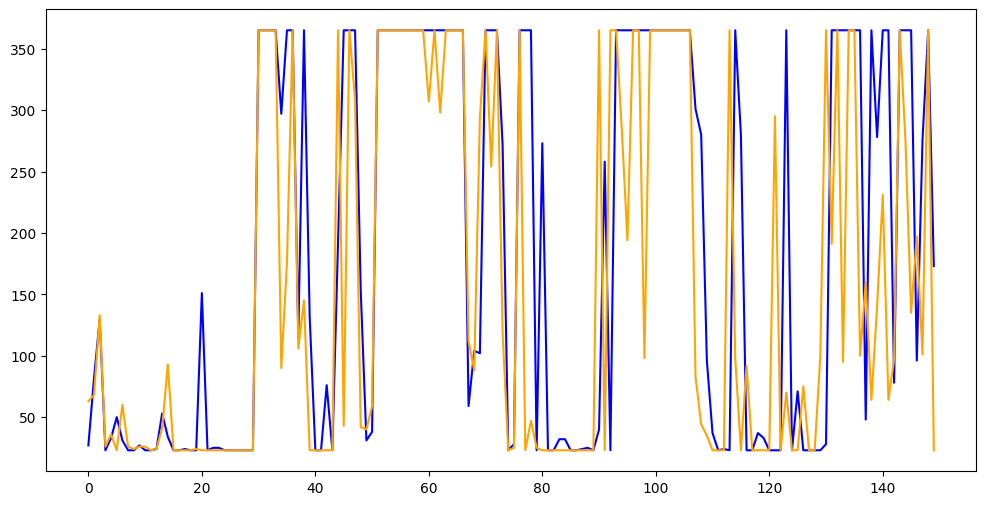

In [ ]:
plt.figure(figsize=(12,6))
plt.plot (train_surived_steps, color='blue')
plt.plot (test_surived_steps, color='orange')

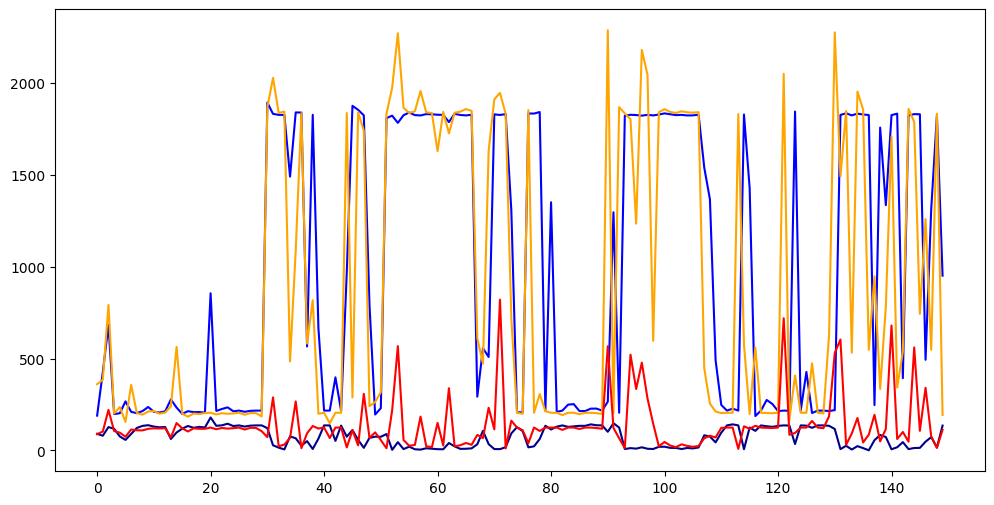

In [ ]:
plt.figure(figsize=(12,6))
plt.plot (train_covered_distance, color='blue')
plt.plot (test_covered_distance, color='orange')
plt.plot (train_bonus_distance, color='darkblue')
plt.plot (test_bonus_distance, color='red')

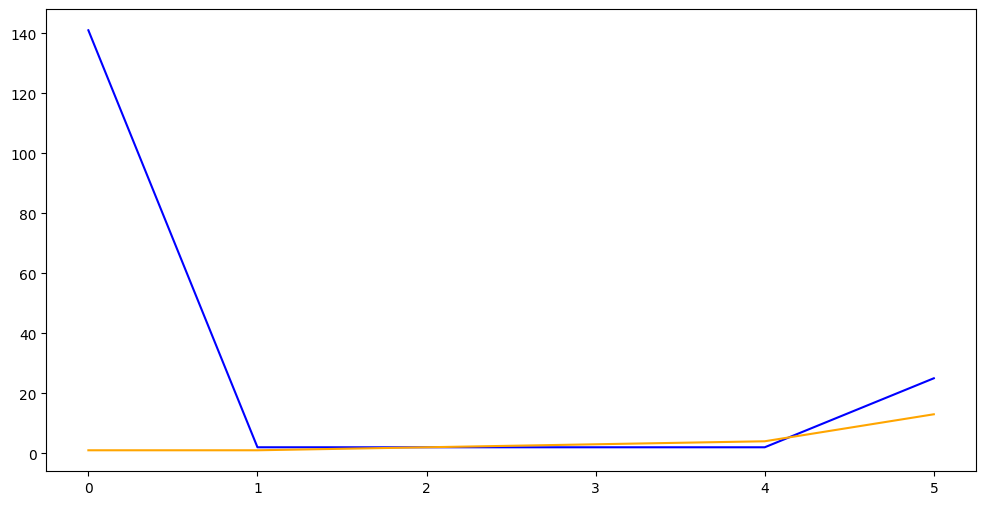

In [ ]:
plt.figure(figsize=(12,6))
plt.plot (train_env.steps_in_locomotion, color='blue')
plt.plot (test_env.steps_in_locomotion, color='orange')

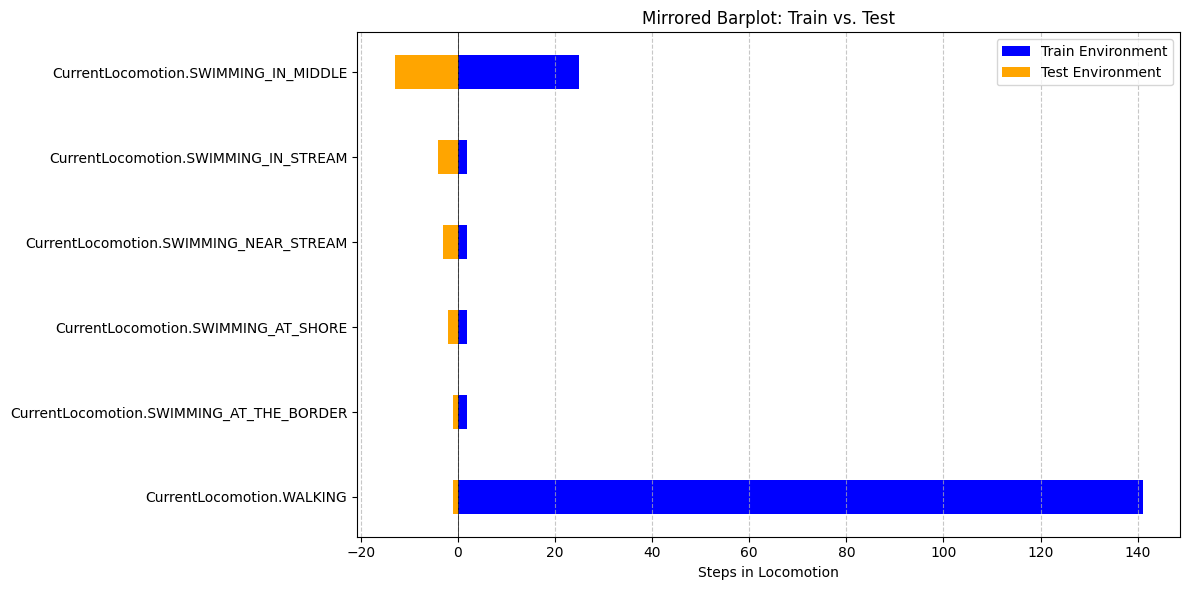

In [ ]:
# Daten
train_env_steps = np.array(train_env.steps_in_locomotion)
test_env_steps = np.array(test_env.steps_in_locomotion)
categories = CurrentLocomotion

# Breite der Balken
bar_width = 0.4

# Erzeuge den Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Position der Kategorien (y-Achse)
y_positions = np.arange(len(categories))

# Barplots: train_env_steps nach links und test_env_steps nach rechts
ax.barh(y_positions, train_env_steps, height=bar_width, color='blue', label='Train Environment')
ax.barh(y_positions, -test_env_steps, height=bar_width, color='orange', label='Test Environment')

# Achsenticks und Labels
ax.set_yticks(y_positions)
ax.set_yticklabels(categories)
ax.set_xlabel('Steps in Locomotion')
ax.set_title('Mirrored Barplot: Train vs. Test')
ax.legend()

# X-Achse spiegeln für die Test-Werte
ax.axvline(0, color='black', linewidth=0.5)  # Linie bei x=0

# Optional: Verbesserung der Lesbarkeit
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Zeige den Plot
plt.tight_layout()
plt.show()


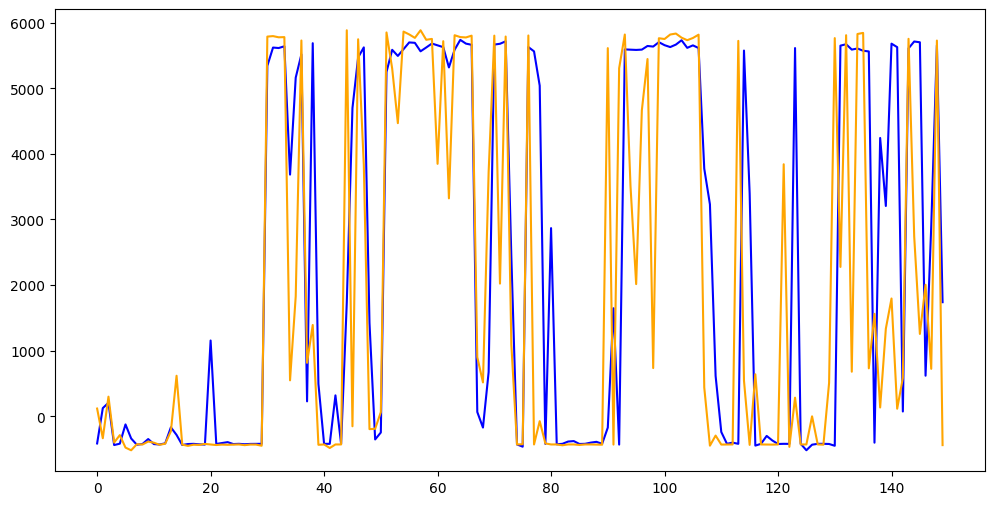

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_rewards, color='blue')
plt.plot(test_rewards, color='orange')

## Fazit

- Reward-Funktion ist essentiell
- Funktioniert, hat z.T. aber rechte Ausreisser
- Achtung mit Enums, Algorithmus geht z.T. nur von positiven Werten aus
- Verhalten in unterschiedlichen Environments (train / test) recht synchron

### Was würden wir tun, wenn wir noch mehr Zeit hätten

- Malus beim versuchten Verlassen des Spielfelds
- Umstellen von Simulation von OpenAI-Gymnasium auf echte Implementation mit [gym-Superklassen](https://gymnasium.farama.org/)
- Testen mit transponierten Werten (Train-Test im gleichen Fluss, dessen Temperatur aber z.B. um ein paar Grad ändern)
- Start und Ende innerhalb Jahr verschieben